`statsmodels` Holt Winters exponential smoothing example. 

Please see: 

  * https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html
  * https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html Note: this notebook is classic stat-writing, as it doesn't call predict! Or, more to the point, it emphasizes inferring de-noised past state.





## Setting up our example

In [1]:
# set up Python
import json
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.api import ExponentialSmoothing
import plotnine
from plotnine import *
from nested_model_fns import plot_model_quality

# set plot size
plotnine.options.figure_size = (16, 8)

In [2]:
d_train = pd.read_csv("d_train.csv")
d_test = pd.read_csv("d_test.csv")

In [3]:
d_train

,time_tick,z_0,x_0,y,ext_regressors
0,0,0,0,63.273288,"z_0: 0, x_0: 0"
1,1,0,1,80.079317,"z_0: 0, x_0: 1"
2,2,0,0,65.403274,"z_0: 0, x_0: 0"
3,3,0,0,66.425156,"z_0: 0, x_0: 0"
4,4,1,0,80.815189,"z_0: 1, x_0: 0"
...,...,...,...,...,...
975,975,0,0,9.283186,"z_0: 0, x_0: 0"
976,976,0,0,10.085011,"z_0: 0, x_0: 0"
977,977,0,0,12.962078,"z_0: 0, x_0: 0"
978,978,0,1,30.791449,"z_0: 0, x_0: 1"


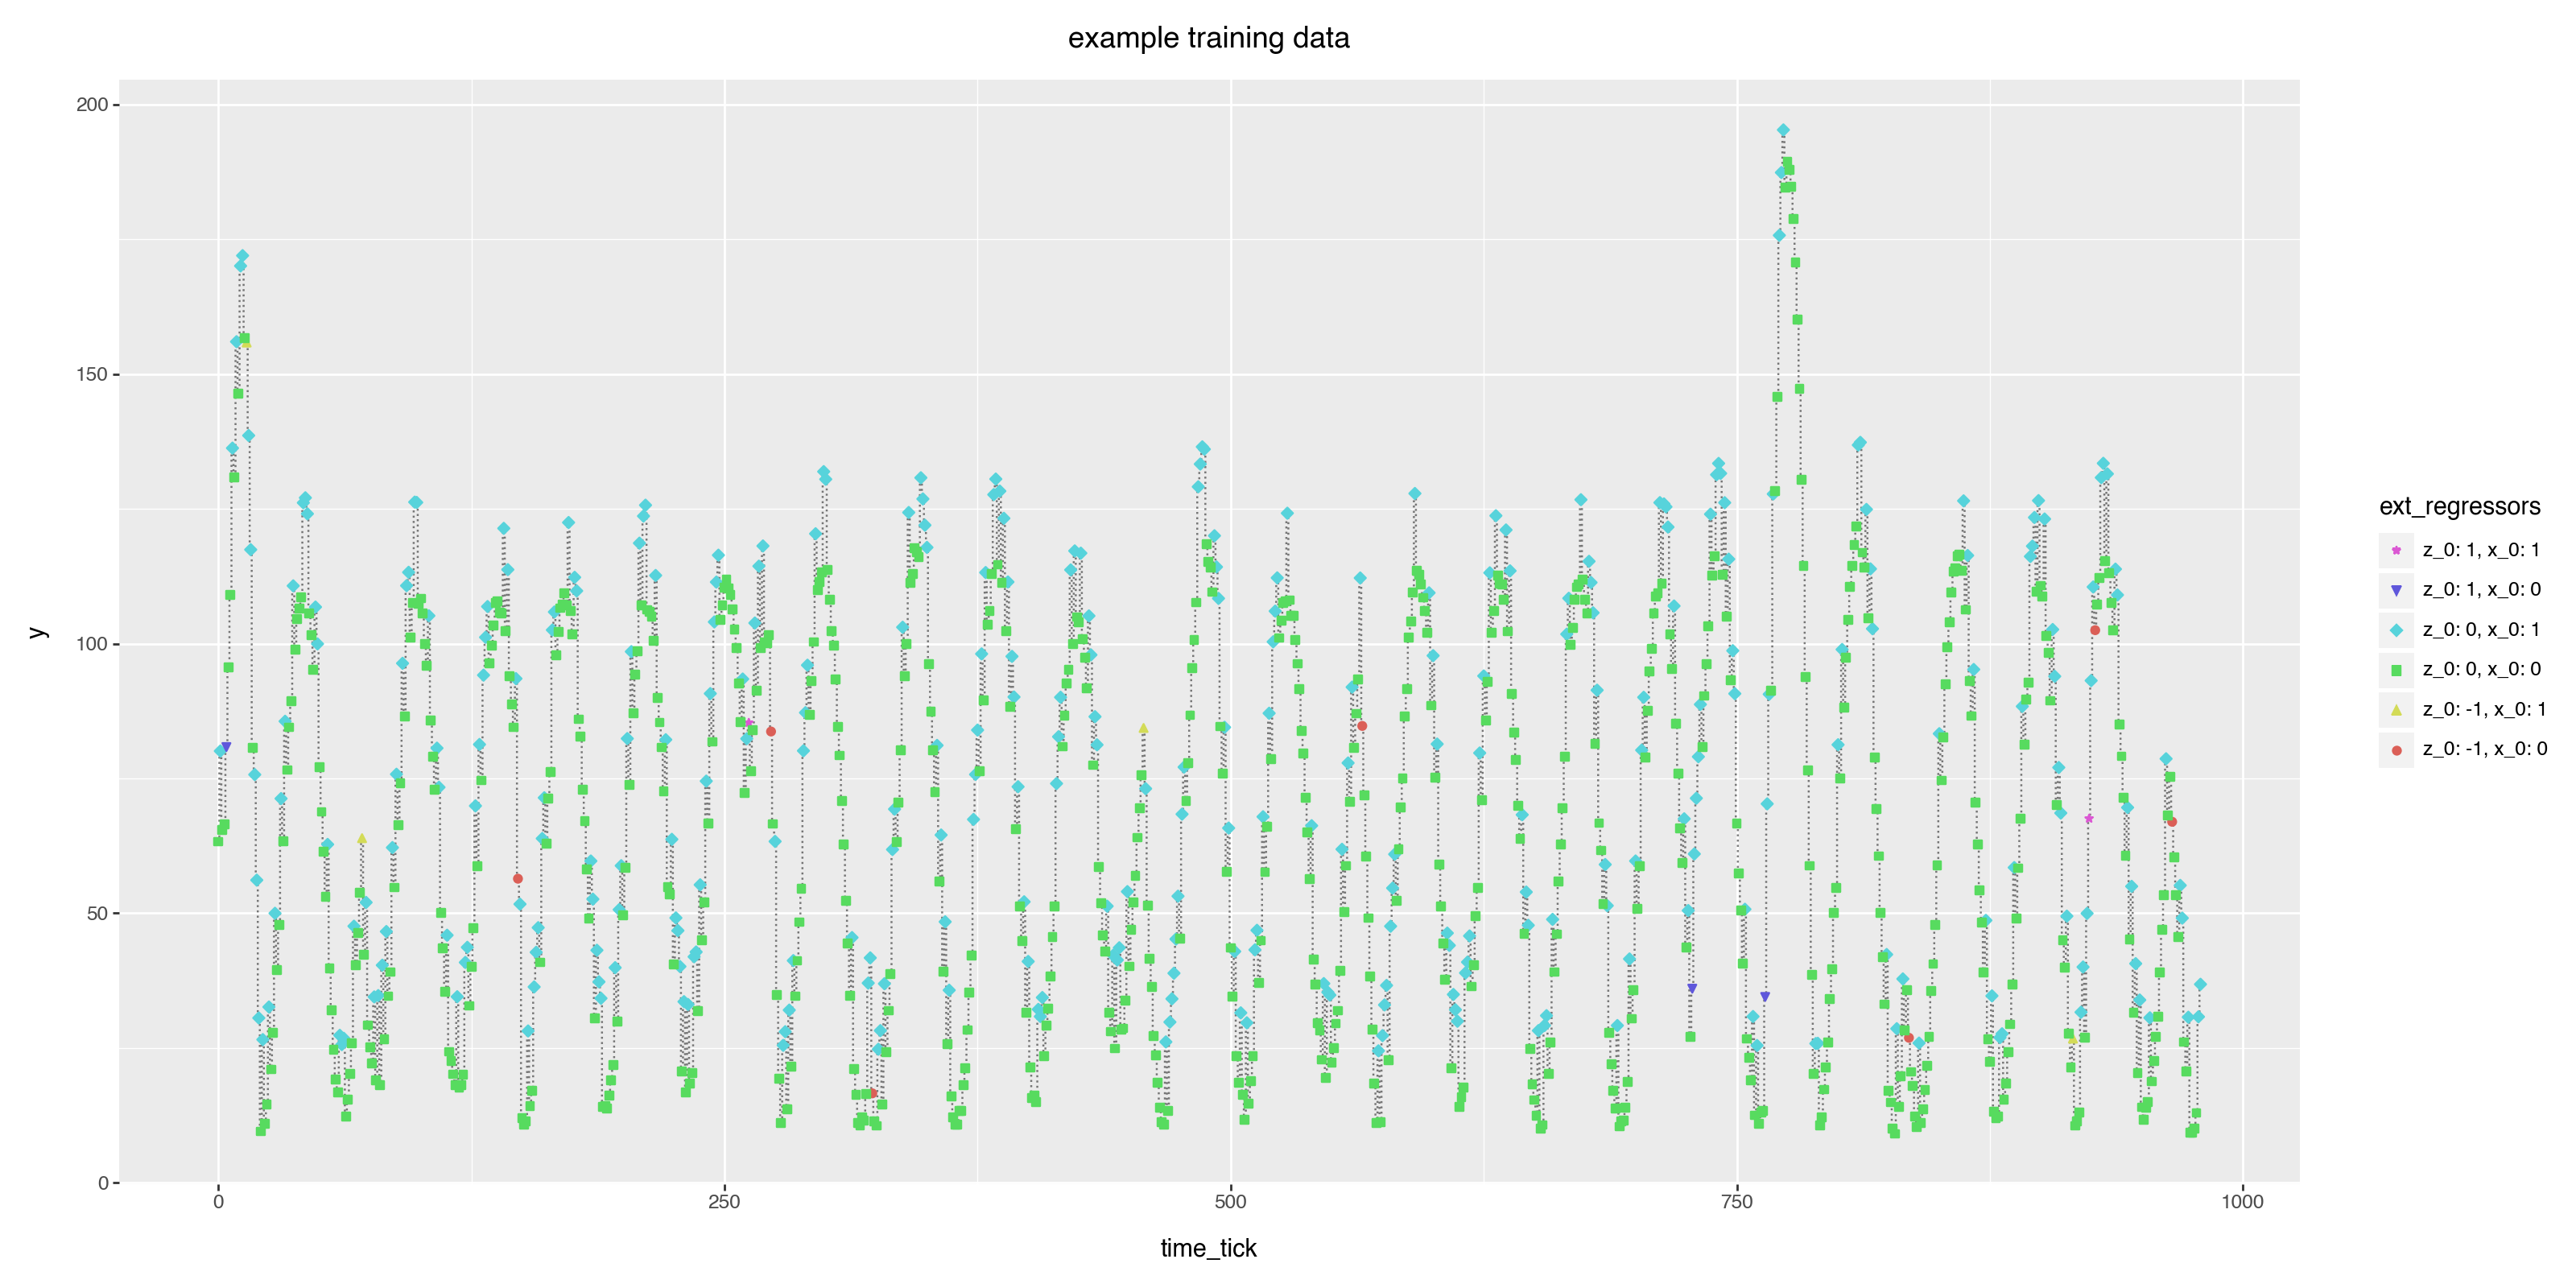

In [4]:
# plot training data
(
    ggplot(data=d_train, mapping=aes(x="time_tick", y="y"))
    + geom_step(
        alpha=0.5,
        direction="mid",
        linetype="dotted",
    )
    + geom_point(mapping=aes(shape="ext_regressors", color="ext_regressors"))
    + guides(shape=guide_legend(reverse=True))
    + ggtitle("example training data")
)

/opt/anaconda3/envs/prob_env/lib/python3.11/site-packages/plotnine/geoms/geom_path.py:100: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


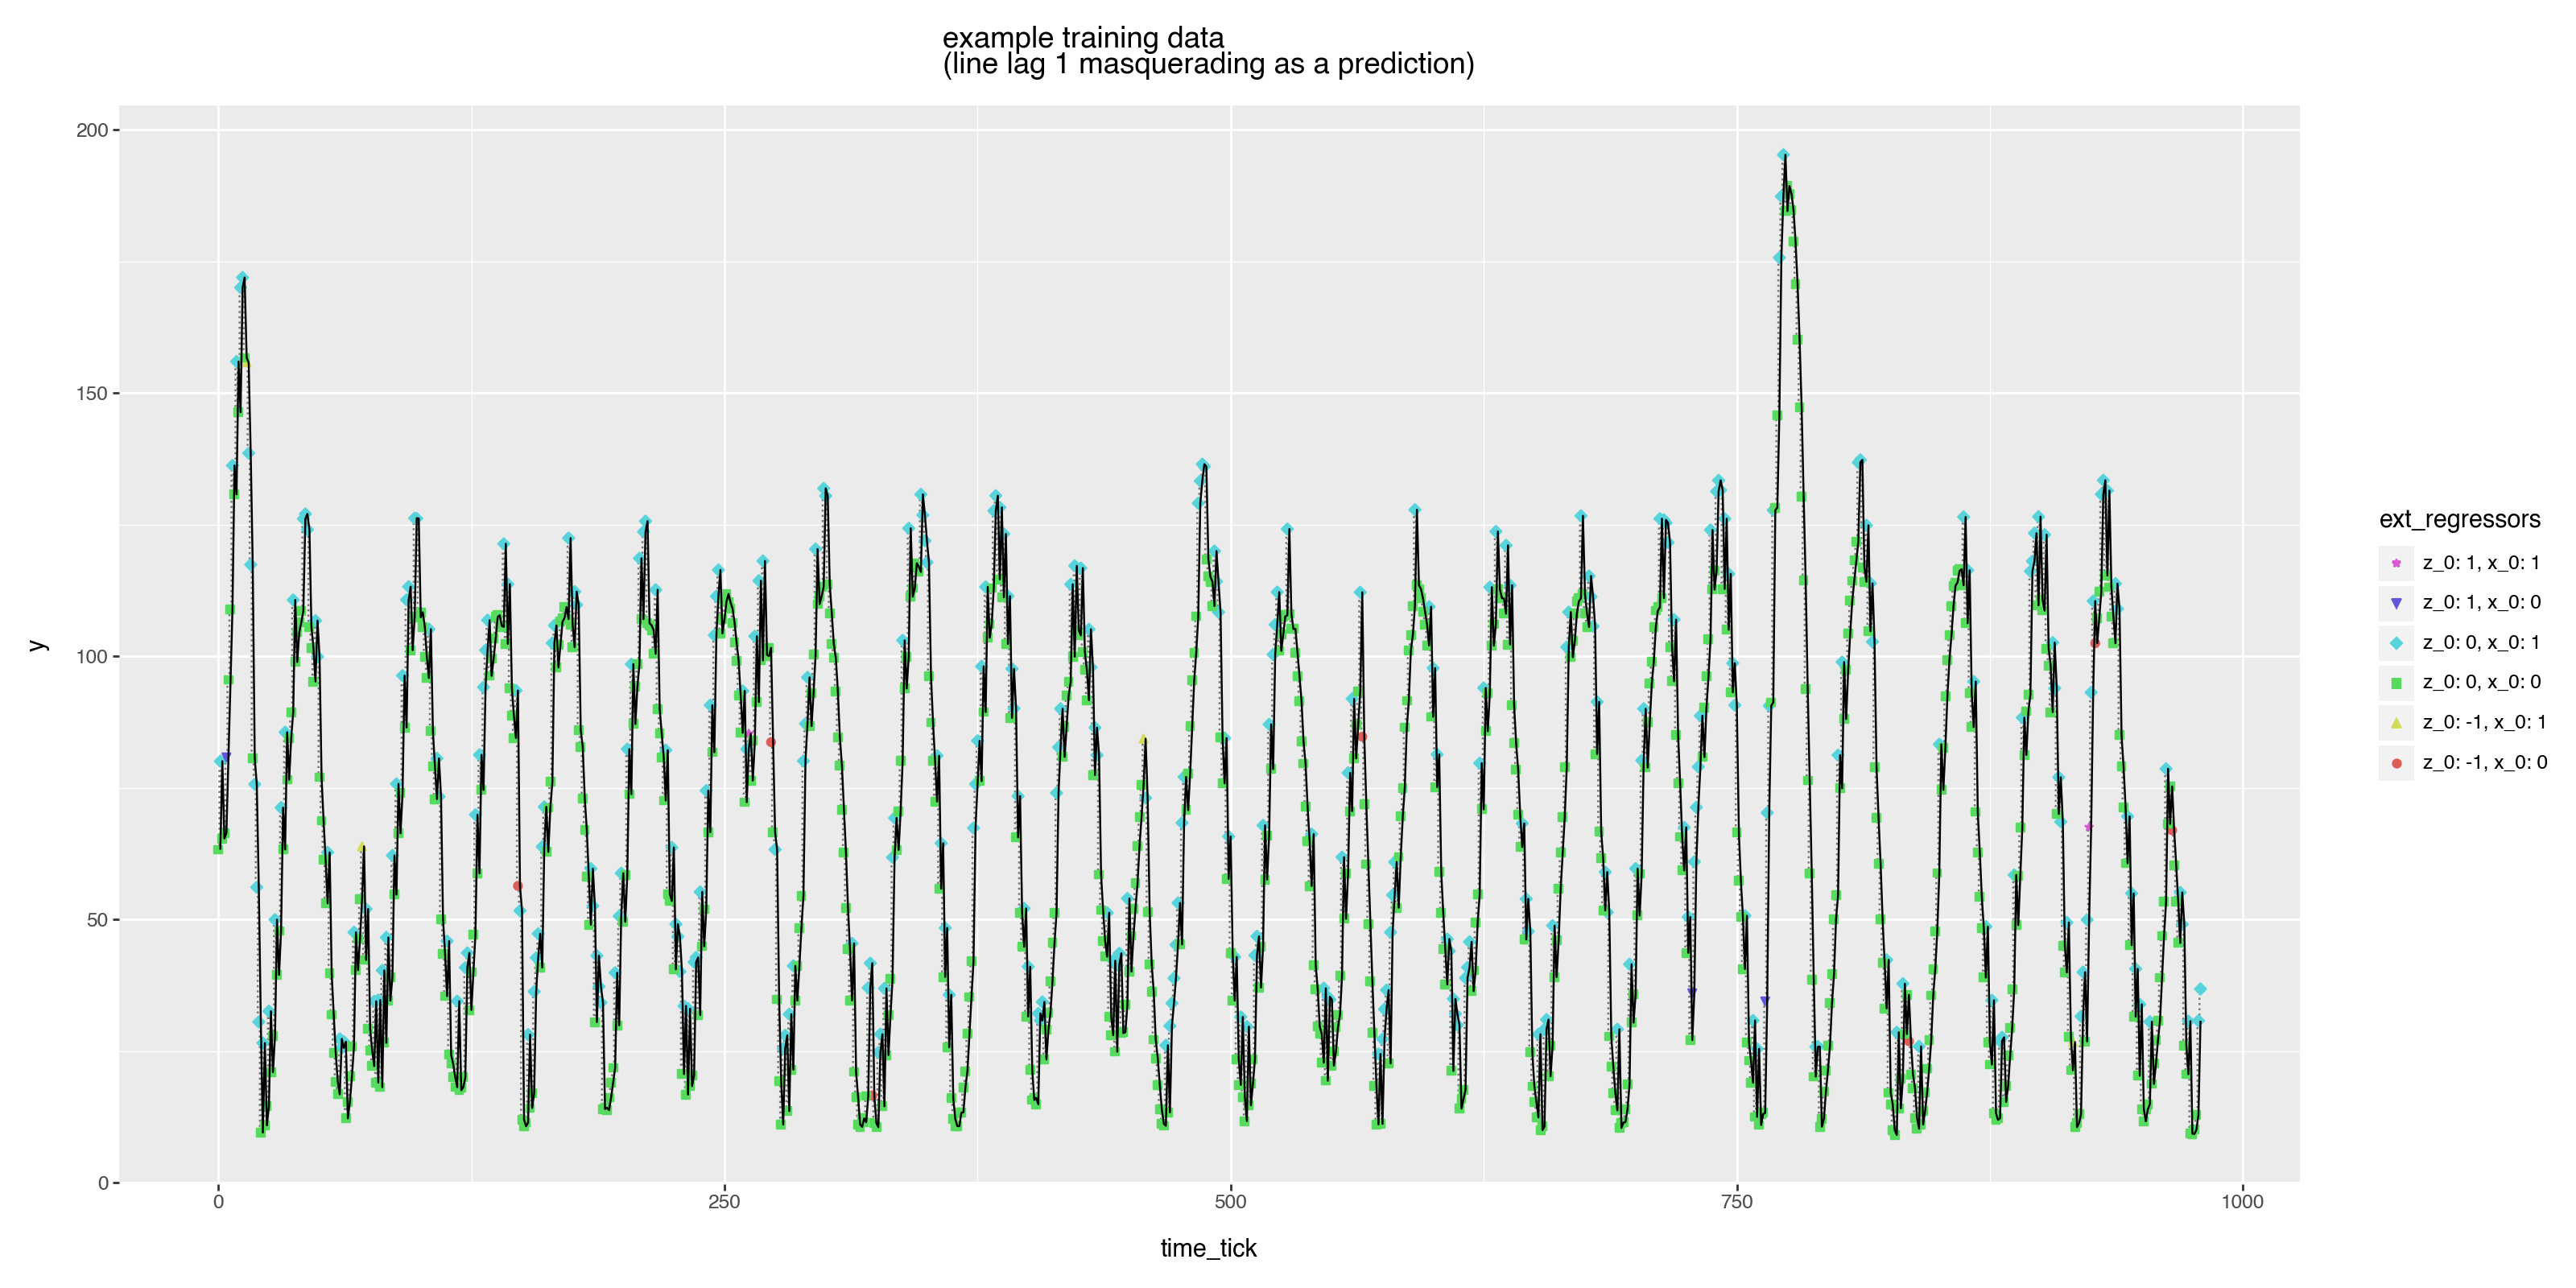

In [5]:
# plot against training data
d_train['lag_1'] = d_train['y'].shift(1, fill_value=np.nan)
(
    ggplot(data=d_train, mapping=aes(x="time_tick", y="y"))
    + geom_step(
        alpha=0.5,
        direction="mid",
        linetype="dotted",
    )
    + geom_point(mapping=aes(shape="ext_regressors", color="ext_regressors"))
    + geom_line(mapping=aes(y='lag_1'))
    + guides(shape=guide_legend(reverse=True))
    + ggtitle("example training data\n(line lag 1 masquerading as a prediction)")
)

In [6]:
d_train.shape

(980, 6)

In [7]:
d_test.shape

(20, 5)

This data set isn't appropriate for the Holt() method. The issues include:

  * The data set has a long and somewhat irregular period (as the exogenous variable can interrupt cycles as seen after time 250).
  * The system isn't very trend-like.
  * The system depends heavily on exogenous variables, which this implementation does not support.

In [8]:
eval_length = 4 * d_test.shape[0]
d_fit = d_train['y'][range(d_train.shape[0] - eval_length)]
d_eval = d_train['y'][range(d_train.shape[0] - eval_length, d_train.shape[0])]

In [9]:
best_mse = None
for seasonal_periods in range(20, 100):
    # search for params by out of sample evaluation for many ticks out
    fit = ExponentialSmoothing(
        d_fit,
        initialization_method="estimated",
        trend='add',
        seasonal='add',
        seasonal_periods=seasonal_periods,
    ).fit(
        use_brute=True
    )
    p_eval = np.array(
        fit.predict(
            start=len(d_fit), 
            end=len(d_fit) + eval_length - 1,
        )
    )
    eval_mse = mean_squared_error(y_true=d_eval, y_pred=p_eval)
    if (best_mse is None) or (eval_mse < best_mse):
        best_mse = eval_mse
        best_seasonal_periods = seasonal_periods

In [10]:
best_seasonal_periods

67

In [11]:
# re-fit whole thing
fit = ExponentialSmoothing(
    d_train['y'],
    initialization_method="estimated",
    trend='add',
    seasonal='add',
    seasonal_periods=best_seasonal_periods,
).fit(
    use_brute=True
)

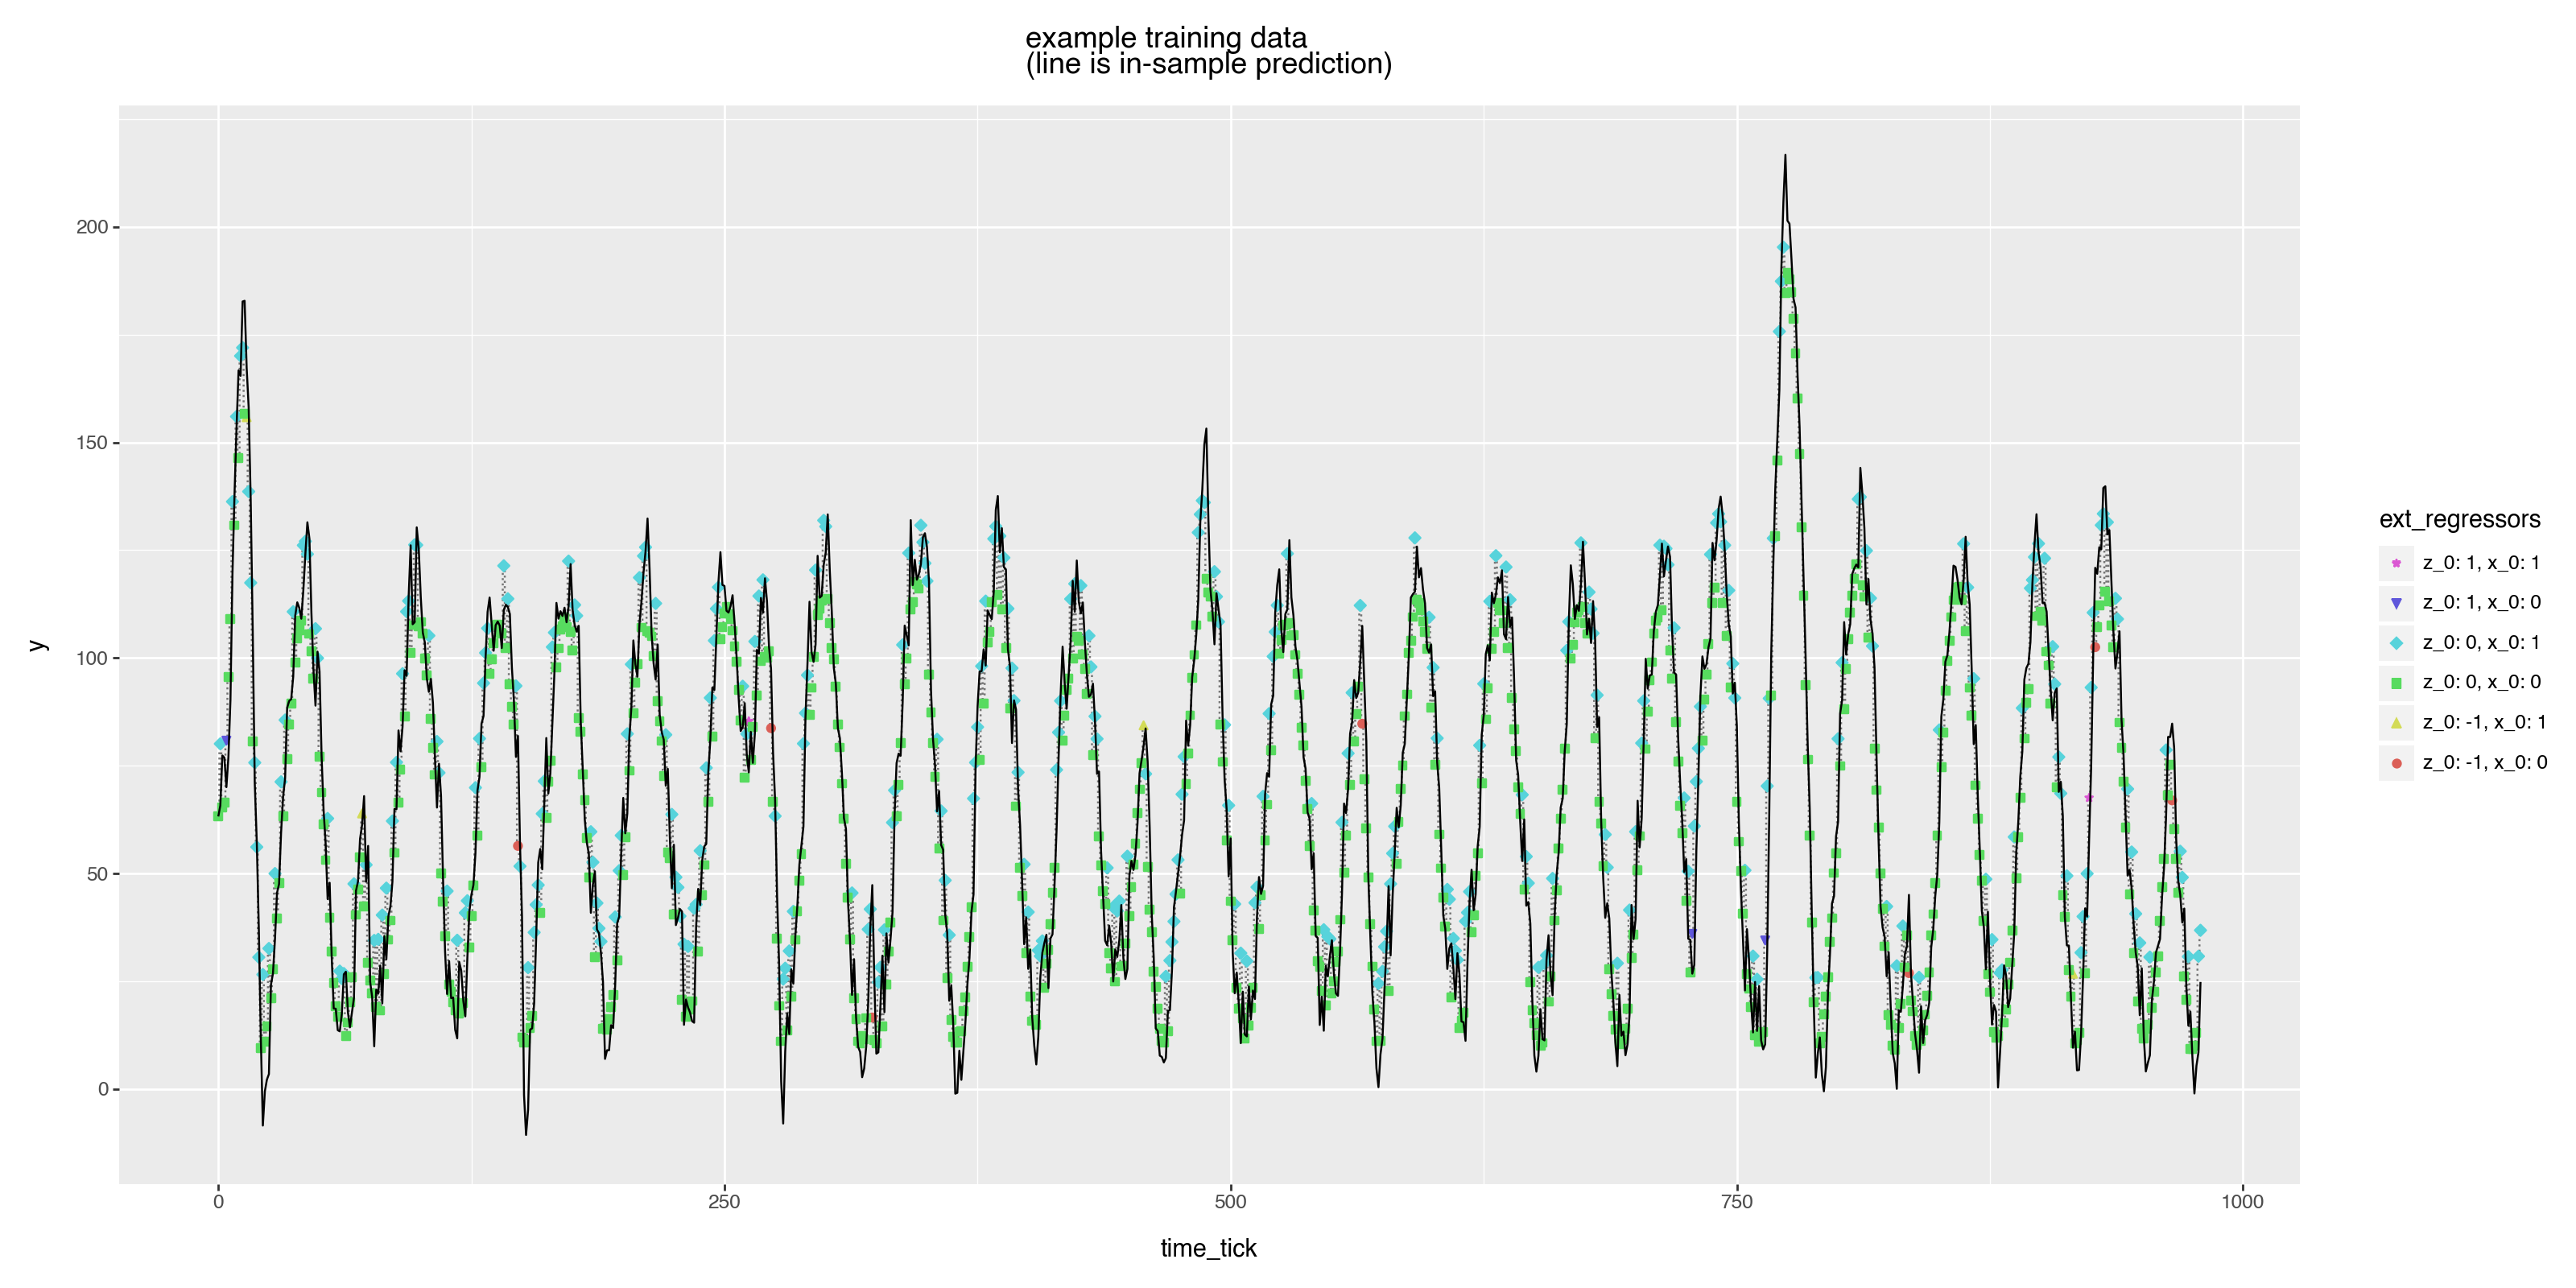

In [12]:
# plot against training data
d_train['prediction'] = fit.fittedvalues
(
    ggplot(data=d_train, mapping=aes(x="time_tick", y="y"))
    + geom_step(
        alpha=0.5,
        direction="mid",
        linetype="dotted",
    )
    + geom_point(mapping=aes(shape="ext_regressors", color="ext_regressors"))
    + geom_line(mapping=aes(y='prediction'))
    + guides(shape=guide_legend(reverse=True))
    + ggtitle("example training data\n(line is in-sample prediction)")
)

Note: the perceived quality of this fit is the usual flaw of evaluating the model only one time period out when we may use the model many time ticks out.

In [13]:
help(fit.predict)

Help on method predict in module statsmodels.tsa.holtwinters.results:

predict(start=None, end=None) method of statsmodels.tsa.holtwinters.results.HoltWintersResultsWrapper instance
    predict(self, start=None, end=None)
    
    In-sample prediction and out-of-sample forecasting
    
    Parameters
    ----------
    start : int, str, or datetime, optional
        Zero-indexed observation number at which to start forecasting, ie.,
        the first forecast is start. Can also be a date string to
        parse or a datetime type. Default is the the zeroth observation.
    end : int, str, or datetime, optional
        Zero-indexed observation number at which to end forecasting, ie.,
        the first forecast is start. Can also be a date string to
        parse or a datetime type. However, if the dates index does not
        have a fixed frequency, end must be an integer index if you
        want out of sample prediction. Default is the last observation in
        the sample.
    
    

In [14]:

d_test["statsmodels HW"] = np.array(
    fit.predict(
        start=d_train.shape[0], 
        end=d_train.shape[0] + d_test.shape[0] - 1,
    )
)

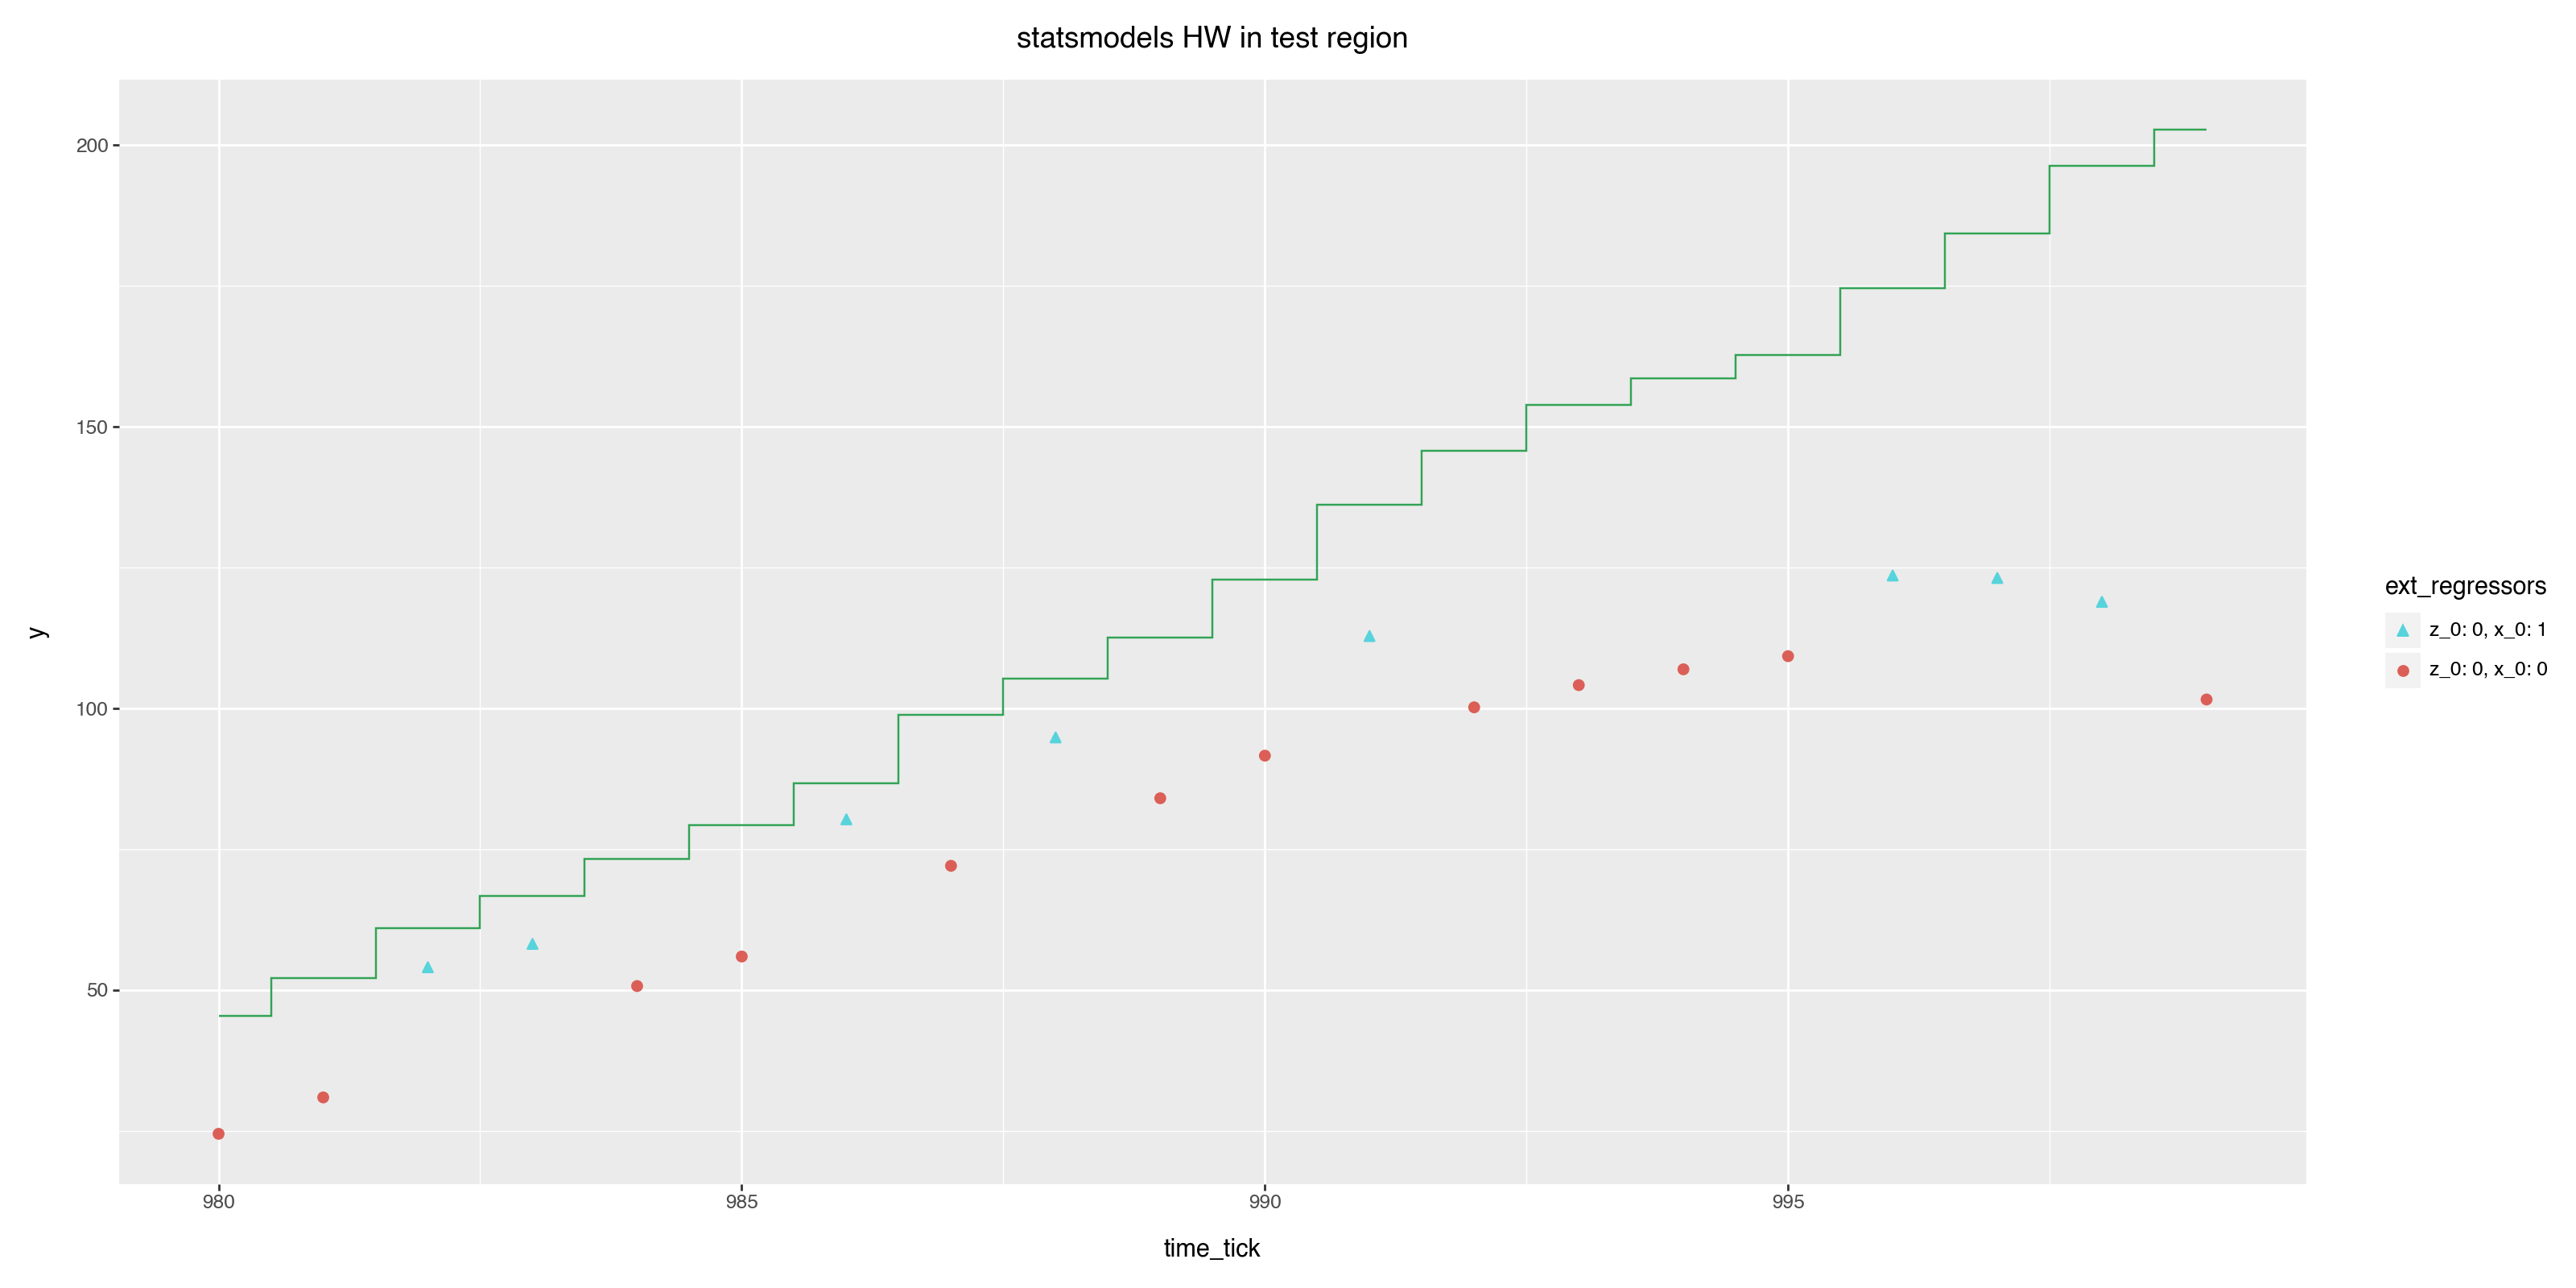

In [15]:
(
    ggplot(
        data=d_test.loc[d_test.notna().all(axis="columns"), :],
        mapping=aes(x="time_tick"),
    )
    + geom_point(
        aes(y="y", shape="ext_regressors", color="ext_regressors"),
        size=2,
    )
    + geom_step(
        aes(y="statsmodels HW"),
        color="#31a354",
        direction="mid",
    )
    + guides(shape=guide_legend(reverse=True))
    + ggtitle("statsmodels HW in test region")
)

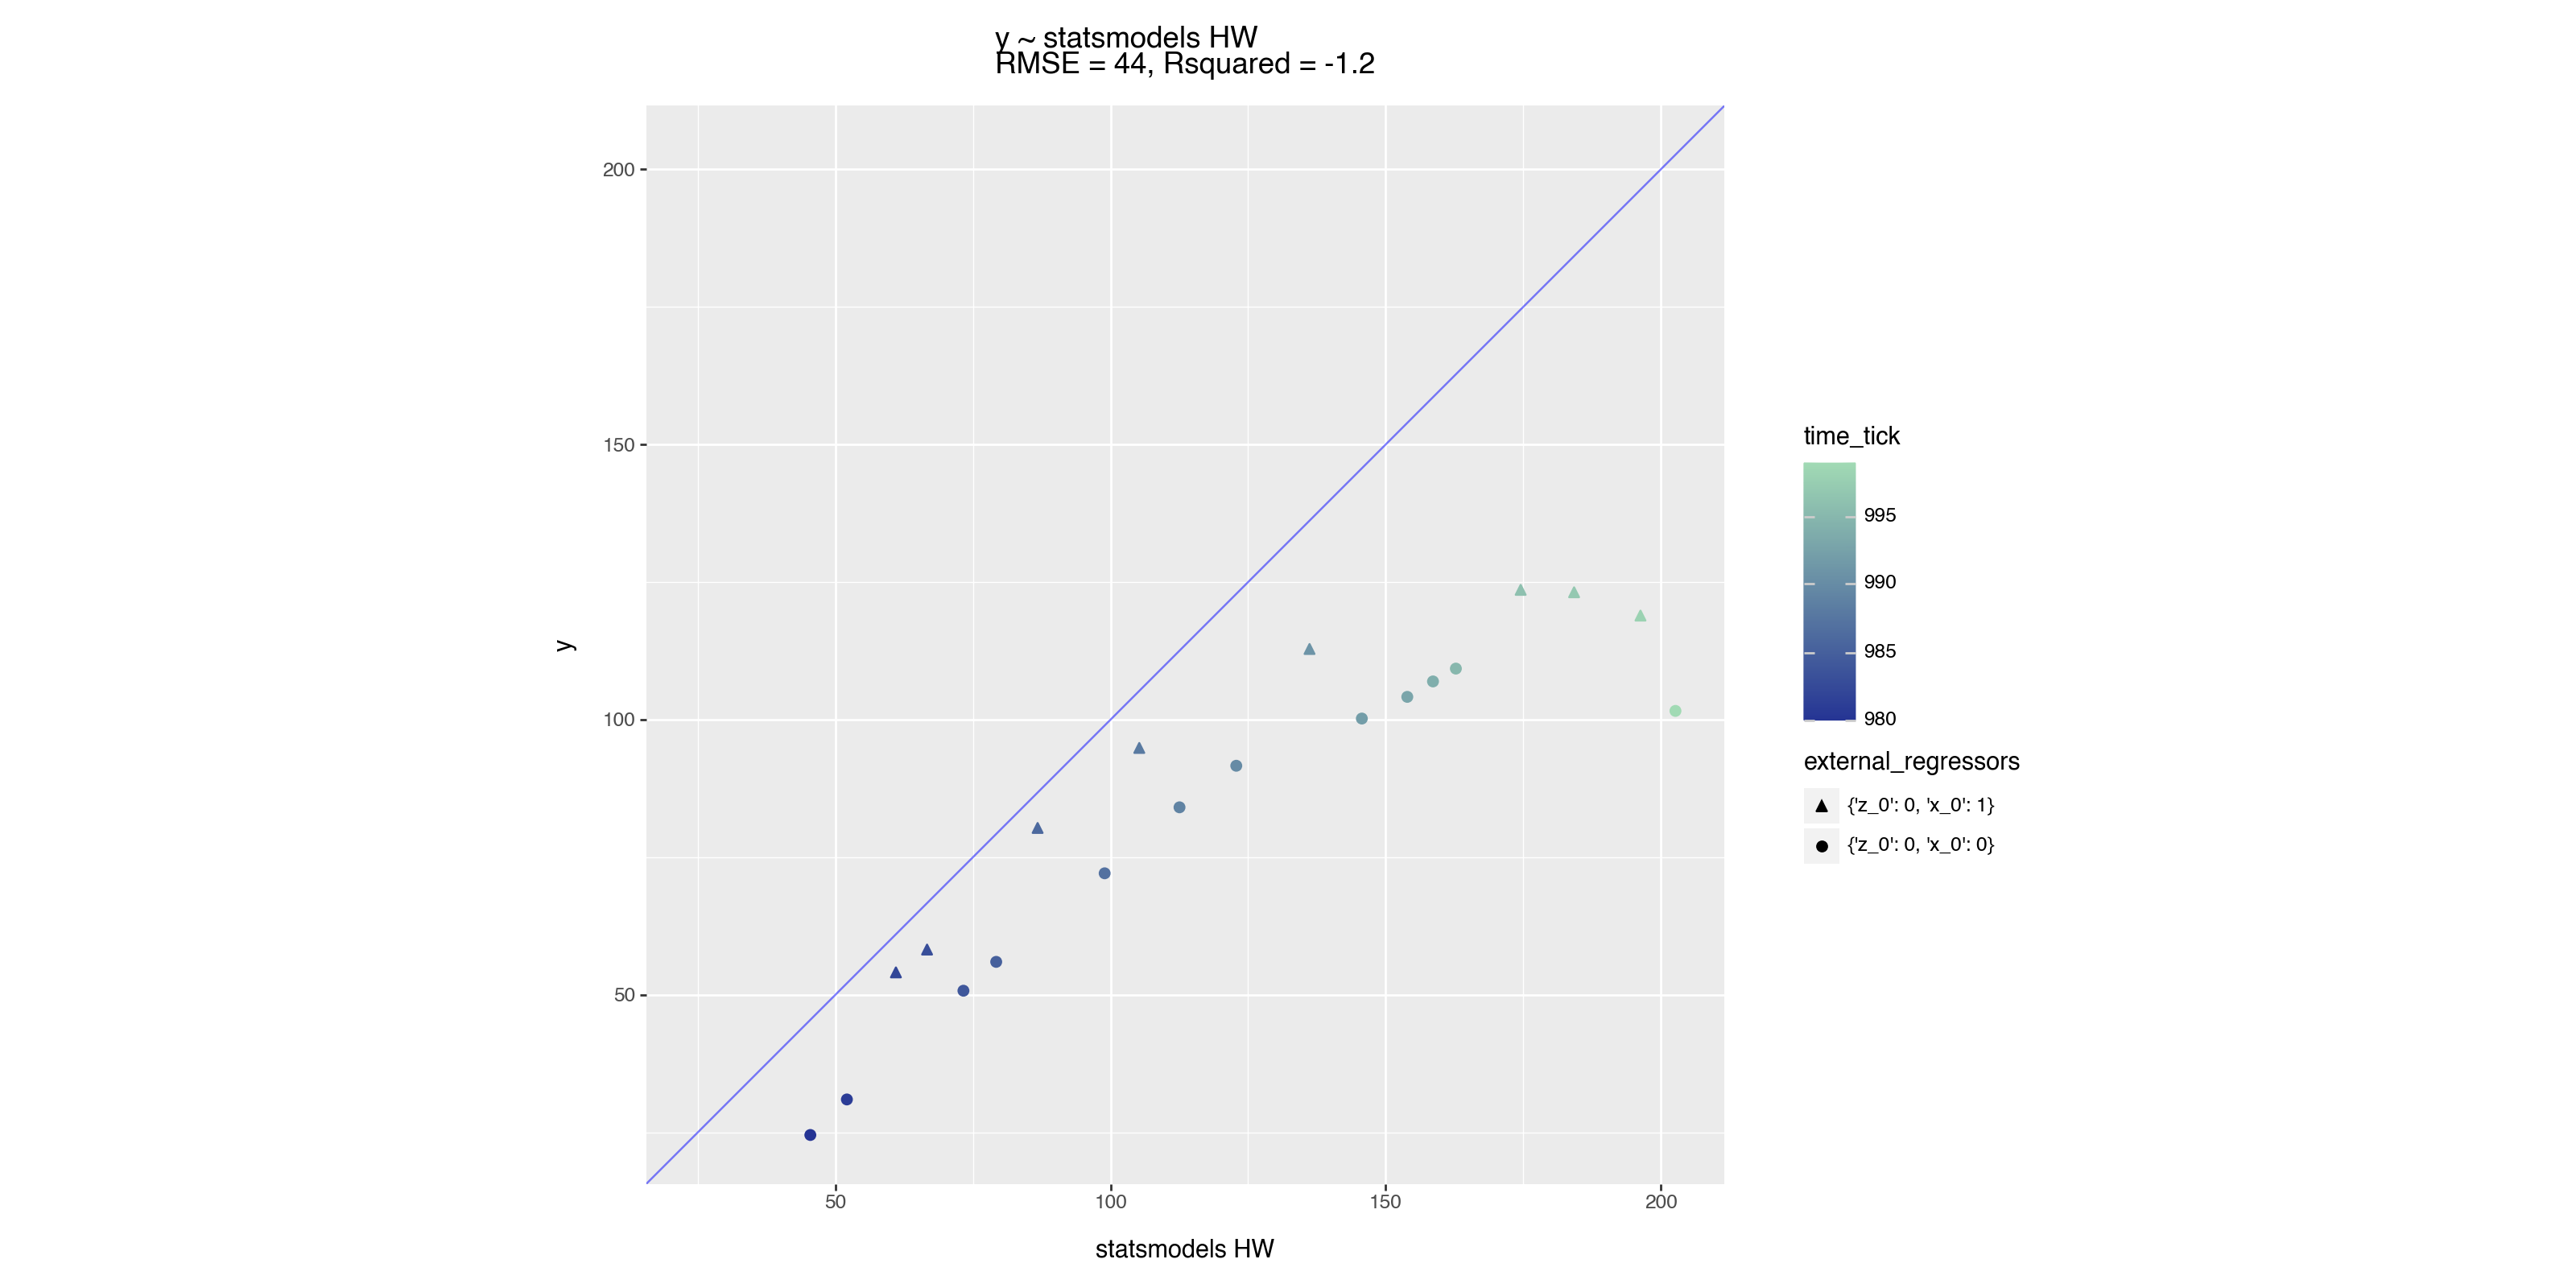

In [16]:
plot_model_quality(
    d_test.loc[
        pd.isnull(d_test["statsmodels HW"]) == False, :
    ],
    result_name="statsmodels HW",
    external_regressors=["z_0", "x_0"],
)